<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/N_S_Temps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installations and imports:
!pip install fsspec
!pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
!pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from google.colab import drive
drive.mount('/content/gdrive')
graph_dir = '/content/gdrive/My Drive/EEPS_1430/EEPS 1430 Final Project/tempgraphs'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
# Reading the CSV and querying for specific data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
ssp585 = df.query("variable_id == 'tas' & experiment_id == 'ssp585' & table_id == 'Amon' & source_id == 'CESM2-WACCM'")
experiment_id = 'ssp585'
source_id = 'CESM2-WACCM'
memnum = '5'
ssp585

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
346677,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585...,NaN,20200702
347006,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r2i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585...,NaN,20200206
347250,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r3i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585...,NaN,20200206
347497,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r4i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585...,NaN,20200206
347744,ScenarioMIP,NCAR,CESM2-WACCM,ssp585,r5i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585...,NaN,20200206


In [3]:
# Printing number of ensemble members in each model for reference
ssp = df.query("variable_id == 'tas' & experiment_id == 'ssp585' & table_id == 'Amon'")
unique_sources = []
for i in ssp['source_id']:
  if i not in unique_sources:
    unique_sources.append(i)
print(unique_sources)

for i in unique_sources:
  x = ssp.query("source_id =="+"'"+i+"'")
  print(str(len(x))+': '+i)

['TaiESM1', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-f3-L', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'IITM-ESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'E3SM-1-1', 'EC-Earth3-Veg-LR', 'EC-Earth3-Veg', 'EC-Earth3', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2-WACCM', 'CESM2', 'NorESM2-LM', 'NorESM2-MM', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4', 'NESM3', 'CIESM', 'MCM-UA-1-0']
1: TaiESM1
1: AWI-CM-1-1-MR
1: BCC-CSM2-MR
2: CAMS-CSM1-0
1: FGOALS-f3-L
4: FGOALS-g3
3: CanESM5-CanOE
50: CanESM5
1: IITM-ESM
1: CMCC-CM2-SR5
1: CNRM-CM6-1-HR
6: CNRM-CM6-1
5: CNRM-ESM2-1
3: ACCESS-CM2
10: ACCESS-ESM1-5
2: MPI-ESM1-2-HR
1: E3SM-1-1
3: EC-Earth3-Veg-LR
5: EC-Earth3-Veg
58: EC-Earth3
3: FIO-ESM-2-0
1: INM-CM4-8
1: INM-CM5-0
6: IPSL-CM6A-LR
1: KIOST-ESM
1: MIROC-ES2L


In [ ]:
# Here I average temperature across the Northern and Southern extratropics separately (where extratropics are defined as North of 24N and South of 24S, as in Schneider et al. (see reference in my paper, the latex file in this github repo)). I then subtract the southern average from the northern at each time interval for for each ensemble member, and put the resulting time series of averages for each time interval into a list.
all_tasMeanAnomalyDiffs = []
for z in range(len(ssp585.zstore.values)):
  print(z)
  zstore = ssp585.zstore.values[z]
  mapper = fsspec.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True, decode_times=True)

  nlon = len(ds.tas.lon)
  tasN = ds.tas.sel(lat=slice(24,90))
  nlat = len(tasN.lat)
  tasN = tasN[:1032]
  print(tasN.time)
  tasN2d = np.reshape(tasN.values, (1032, nlat*nlon))
  tasNspacemean = np.mean(tasN2d, axis=1) # Averaging along lat & lon
  tasN12months = np.reshape(tasNspacemean, (86, 12))
  tasNmean = np.mean(tasN12months, axis=1) # Average for each year
  tasNmeanAnomaly = tasNmean - tasNmean[0] # Anomaly
  # plt.plot(tasNmeanAnomaly)
  # plt.title('Northern Anomalies 2015-2100')
  # plt.show()

  tasS = ds.tas.sel(lat=slice(-90, -24))
  nlat = len(tasS.lat)
  tasS = tasS[:1032]
  print(tasS.time)
  tasS2d = np.reshape(tasS.values, (1032, nlat*nlon))
  tasSspacemean = np.mean(tasS2d, axis=1)
  tasS12months = np.reshape(tasSspacemean, (86, 12))
  tasSmean = np.mean(tasS12months, axis=1)
  tasSmeanAnomaly = tasSmean - tasSmean[0]
  # plt.plot(tasSmeanAnomaly)
  # plt.title('Southern Anomalies')
  # plt.show()

  tasMeanAnomalyDiff = tasNmeanAnomaly - tasSmeanAnomaly # Difference in N and S hemisphere anomalies
  all_tasMeanAnomalyDiffs.append(tasMeanAnomalyDiff)
  # plt.plot(tasMeanAnomalyDiff)
  # plt.title('Northern minus Southern anomalies')
  # plt.ylabel('Temp (K)')
  # plt.show()

Text(0, 0.5, 'Temperature anomaly difference (K)')

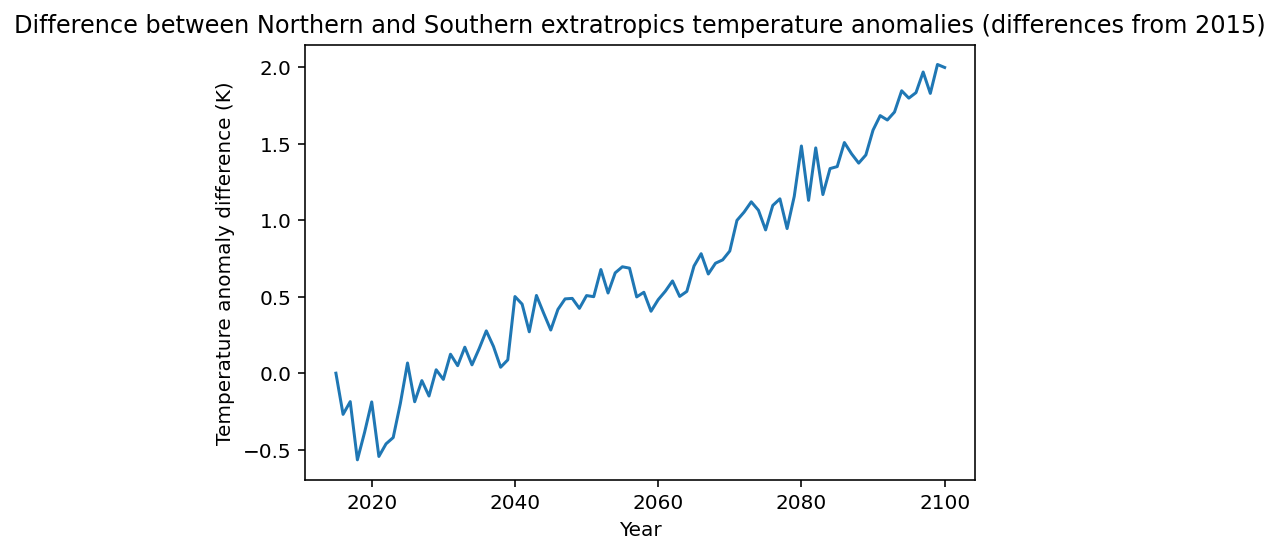

In [5]:
Here I convert the list of time series to a numpy array and then take the mean of that array along the 0th dimension to get a mean across ensemble members. I save the resulting array as a csv file for analysis in another script and plot the change in temperature difference against time for fun.

# Making a list of years for plotting:
years = np.array(ds['time.year'])
unique_years = []
for i in years:
  if i not in unique_years:
    unique_years.append(i)

all_nparray = np.array([i for i in all_tasMeanAnomalyDiffs])
finalAvg = np.mean(all_nparray, axis=0)
ssp585_dir = '/content/gdrive/My Drive/EEPS_1430/EEPS 1430 Final Project/ssp585'
np.savetxt(ssp585_dir+'/'+experiment_id+"_"+source_id+"_memnum"+memnum+"_tempAvgs.csv", finalAvg, delimiter=',')
plt.plot(unique_years, finalAvg)
plt.title('Difference between Northern and Southern extratropics temperature anomalies (differences from 2015)')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly difference (K)')
# plt.savefig(f"{graph_dir}/"+experiment_id+"_"+source_id+"_memnum"+memnum+"_temp_graph.png")